In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Z-score normalization
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # Import MNIST dataset
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.64MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 256), # Expand from noise vector to hidden representation
            nn.BatchNorm1d(256), # Batch normalization to stabilize training
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 28*28),
            nn.Tanh() # Tanh so that we match normalized image output
            )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512), # Process input image
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),  # Dropout for regularization

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid() # Outputs probability between 0 and 1
            )

    def forward(self, x):
        return self.net(x)

In [ ]:
def show_generated_images(images):
    images = images.view(-1, 1, 28, 28)
    images = images.cpu().data
    grid = torch.cat([img for img in images[:16]], dim=2).squeeze()
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 128
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

loss_fn = nn.BCELoss() # Loss from the paper is similar to BCE
lr = 0.0001

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

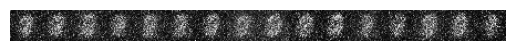

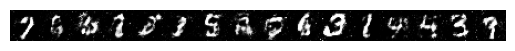

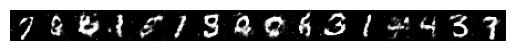

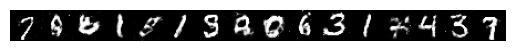

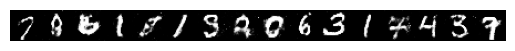

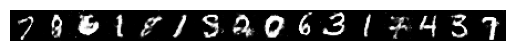

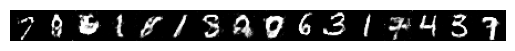

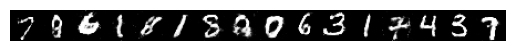

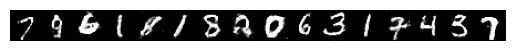

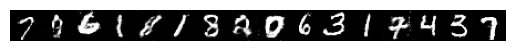

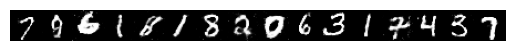

In [ ]:
epochs = 300
fixed_noise = torch.randn(16, noise_dim).to(device) # This allows us to see how the generator improves over time with the same input

for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", leave = False)
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.view(batch_size, -1).to(device)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, noise_dim).to(device) # Generate random noise for fake image generation
        fake_imgs = generator(z)

        # Train discriminator on real images
        outputs = discriminator(real_imgs)
        d_loss_real = loss_fn(outputs, real_labels) # How well it identifies real images

        # Train discriminator on fake images
        outputs = discriminator(fake_imgs.detach()) # .detach() stops gradients to generator
        d_loss_fake = loss_fn(outputs, fake_labels) # How well it identifies fake images

        d_loss = d_loss_real + d_loss_fake

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        z = torch.randn(batch_size, noise_dim).to(device) # Generate new fake images
        fake_imgs = generator(z)
        outputs = discriminator(fake_imgs)
        g_loss = loss_fn(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())
    if (epoch + 1) % 30 == 0 or epoch == 0:
        with torch.no_grad() :
            fake_imgs = generator(fixed_noise)
            show_generated_images(fake_imgs)